<a href="https://colab.research.google.com/github/Jvitormx/4UBD_ProjetoAnaliseDados_GoogleColab/blob/main/4UBD_An%C3%A1liseTaxaHomic%C3%ADdios100milPorUF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Título e Introdução

## Título

**Análise da Taxa de Homicídios por 100.000 Habitantes por UF (2001–2021)**


## Introdução

A violência é um dos principais desafios de segurança pública no Brasil. O país registra milhares de homicídios dolosos por ano, com grande variação entre estados e regiões.  
Para comparar o risco de homicídio de forma justa, levando em conta que estados têm populações muito diferentes, utiliza-se uma **taxa de homicídios por 100.000 habitantes por UF**, que permite identificar quais Unidades da Federação enfrentam maiores desafios relativos de violência, independentemente de seu tamanho populacional.

O objetivo deste trabalho é analisar a evolução dessa taxa em cada UF entre 2001 e 2021, explorando padrões regionais e tendências ao longo do tempo.

**Fontes de dados**  
- **Atlas da Violência (IPEA)**: contém a contagem anual de homicídios dolosos UF entre 1989 - 2023 (`homicidios.csv`).  
- **SIDRA/IBGE (Tabela 6579)**: traz estimativa de população residente por UF entre 2001 - 2021 (`tabela6579.xlsx`).


# 2. Aquisição dos Dados

Nesta etapa são carregados os dois conjuntos de dados necessários:

1. **Homicídios**: Um arquivo .csv com a contagem anual de homicídios dolosos por UF, extraída do Atlas da Violência (IPEA).  
2. **População**: Um arquivo .xlsx com as estimativas anuais de população residente por UF, obtidas no SIDRA/IBGE (Tabela 6579).

*Observação 1*: Os arquivos foram baixados manualmente dos respectivos portais e estão disponíveis no diretório `/sample_data` do Colab.

*Observação 2*: Considerei utilizar a API de Ocorrências Criminais do SINESP, disponibilizada em 'http://ec2-54-174-4-15.compute-1.amazonaws.com/api', ou a tabela com a compilação dos mesmos dados, como alternativa de fonte de dados para a contagem de homicídios por UF, porém a API não se encontra em funcionamento e a tabela não apresenta uma range satisfatória, sendo ela de 2015 até 2022. Além disso, a tabela apresenta mais dados desnecessários comparada com a do Atlas da Violência.

In [ ]:
import pandas as pd

# 2.1. Homicídios
url_hom = 'sample_data/homicidios.csv'

df_hom = pd.read_csv(url_hom, encoding='utf-8')
print(df_hom)

# 2.2. População
url_pop = 'sample_data/tabela6579.xlsx'

# A planilha tem cabeçalhos extras nas primeiras linhas, por isso pulei 2 linhas
df_pop = pd.read_excel(url_pop, sheet_name='Tabela', skiprows=2)
print(df_pop)

    cod;nome;período;valor
0           25;PB;1989;461
1            16;AP;1989;39
2           15;PA;1989;666
3           21;MA;1989;411
4          41;PR;1989;1112
..                     ...
940         22;PI;2023;725
941        26;PE;2023;3698
942         24;RN;2023;955
943        51;MT;2023;1105
944        35;SP;2023;3043

[945 rows x 1 columns]
                      Unidade da Federação         Ano  Unnamed: 2  \
0                                      NaN      2001.0      2002.0   
1                                 Rondônia   1407886.0   1431777.0   
2                                     Acre    574355.0    586942.0   
3                                 Amazonas   2900240.0   2961801.0   
4                                  Roraima    337237.0    346871.0   
5                                     Pará   6341736.0   6453683.0   
6                                    Amapá    498735.0    516511.0   
7                                Tocantins   1184895.0   1207014.0   
8                     

**Comentários sobre a origem dos dados**  
- **Atlas da Violência (IPEA)**  
  - Download manual do CSV na série 'homicídio' em:  
    https://www.ipea.gov.br/atlasviolencia/filtros-series/1/homicidios  
- **SIDRA/IBGE (Tabela 6579)**  
  - Download manual do XLSX em:  
    https://sidra.ibge.gov.br/tabela/6579  

# 3. Limpeza e Preparação


## 3.1. Estruturação do DataFrame de homicídios

O CSV veio com todos os campos em uma única coluna separados por `;`, então é necessário:

1. **Dividir** essa coluna em 4.
2. **Renomear** as colunas para `cod`, `UF`, `Ano`, `Homicídios`.
3. **Selecionar** apenas as colunas necessárias.


In [ ]:
# 3.1. Estruturação do df_hom

# split da coluna única
df_hom = df_hom['cod;nome;período;valor'].str.split(';', expand=True).rename(columns={0:'cod',1:'UF',2:'Ano',3:'Homicídios'})

# converter tipos
df_hom['Ano'] = df_hom['Ano'].astype(int)
df_hom['Homicídios'] = pd.to_numeric(df_hom['Homicídios'], errors='coerce')

# manter só colunas essenciais
df_hom = df_hom[['UF','Ano','Homicídios']]

df_hom.head()


,UF,Ano,Homicídios
0,PB,1989,461
1,AP,1989,39
2,PA,1989,666
3,MA,1989,411
4,PR,1989,1112


## 3.2. Estruturação do DataFrame de população

O arquivo .xlsx traz a população em colunas de anos, com uma estrutura "wide". É necessário:

1. **Renomear** a coluna de UF.
2. **Eliminar** linhas de rodapé.
3. **Transformar** a estrutura da tabela de "wide" para "long" (`melt`), obtendo colunas `UF`, `Ano`, `População`, para que seu df fique similar df de homicícios.
4. **Converter** os tipos `Ano` → `int`, `População` → `int`.


In [ ]:
# 3.2. Estruturação do df_pop

# Leitura pulando as 2 primeiras linhas; a 3ª tem os anos.
df_pop_raw = pd.read_excel(url_pop, sheet_name='Tabela', skiprows=2)

# Capturar a 1ª linha como mapeamento de coluna→ano
year_row = df_pop_raw.iloc[0]
year_mapping = {
    col: int(year)
    for col, year in year_row.items()
    if col != df_pop_raw.columns[0] and pd.notna(year)
}

# Remover a linha de anos e renomear a coluna de UF
df_pop_cleaned = (
    df_pop_raw
    .iloc[1:]  # descarta a linha de cabeçalho de anos
    .rename(columns={df_pop_raw.columns[0]: 'UF'})
)

# Remover rodapés (linhas cujo UF contenha “Fonte:” ou esteja vazio)
df_pop_cleaned = df_pop_cleaned[
    df_pop_cleaned['UF'].notna() &
    ~df_pop_cleaned['UF'].str.contains('Fonte:', na=False)
]

# Melt de wide para long
cols_to_melt = [c for c in df_pop_cleaned.columns if c != 'UF']
pop_long = df_pop_cleaned.melt(
    id_vars=['UF'],
    value_vars=cols_to_melt,
    var_name='Ano_col',
    value_name='População'
)

# Mapeamento Ano_col → Ano real, descartar Ano_col e resetar índice
df_pop = (
    pop_long
    .assign(Ano=pop_long['Ano_col'].map(year_mapping))
    .drop(columns='Ano_col')
    .reset_index(drop=True)
)

# Conversão de tipos
df_pop['Ano'] = df_pop['Ano'].astype(int)
df_pop['População'] = pd.to_numeric(df_pop['População'], errors='coerce').fillna(0).astype(int)

# Visualizar o resultado
df_pop.head()
print(df_pop)

                     UF  População   Ano
0              Rondônia    1407886  2001
1                  Acre     574355  2001
2              Amazonas    2900240  2001
3               Roraima     337237  2001
4                  Pará    6341736  2001
..                  ...        ...   ...
508   Rio Grande do Sul   11466630  2021
509  Mato Grosso do Sul    2839188  2021
510         Mato Grosso    3567234  2021
511               Goiás    7206589  2021
512    Distrito Federal    3094325  2021

[513 rows x 3 columns]


## 3.3. Padronização de nomes de UF, mapeamento dos UFs e filtragem de anos

1. **Maiúsculas** e remoção de espaços.
2. **Filtrar** apenas anos entre 2001 e 2021.


In [ ]:
# padronizar UF
df_hom['UF'] = df_hom['UF'].str.upper().str.strip()
df_pop['UF'] = df_pop['UF'].str.upper().str.strip()

# definir período de interesse
anos = list(range(2001, 2022))
df_hom = df_hom[df_hom['Ano'].isin(anos)]
df_pop = df_pop[df_pop['Ano'].isin(anos)]

print("homicídios:", df_hom['Ano'].min(), "-", df_hom['Ano'].max())
print("população:  ", df_pop['Ano'].min(), "-", df_pop['Ano'].max())

# Mapeamento de nomes completos de UF para siglas
uf_mapping = {
    'RONDÔNIA': 'RO',
    'ACRE': 'AC',
    'AMAZONAS': 'AM',
    'RORAIMA': 'RR',
    'PARÁ': 'PA',
    'AMAPÁ': 'AP',
    'TOCANTINS': 'TO',
    'MARANHÃO': 'MA',
    'PIAUÍ': 'PI',
    'CEARÁ': 'CE',
    'RIO GRANDE DO NORTE': 'RN',
    'PARAÍBA': 'PB',
    'PERNAMBUCO': 'PE',
    'ALAGOAS': 'AL',
    'SERGIPE': 'SE',
    'BAHIA': 'BA',
    'MINAS GERAIS': 'MG',
    'ESPÍRITO SANTO': 'ES',
    'RIO DE JANEIRO': 'RJ',
    'SÃO PAULO': 'SP',
    'PARANÁ': 'PR',
    'SANTA CATARINA': 'SC',
    'RIO GRANDE DO SUL': 'RS',
    'MATO GROSSO DO SUL': 'MS',
    'MATO GROSSO': 'MT',
    'GOIÁS': 'GO',
    'DISTRITO FEDERAL': 'DF'
}

# Aplicar o mapeamento ao DataFrame df_pop
df_pop['UF'] = df_pop['UF'].map(uf_mapping)

# Verificar se há UFs que não foram mapeadas (deveria ser None se não encontrou)
print("UFs não mapeadas em df_pop (deve ser vazio se tudo deu certo):")
print(df_pop[df_pop['UF'].isna()]['UF'].unique())

# Agora os nomes das UFs em df_pop devem ser siglas, como em df_hom
print("\nPrimeiras linhas de df_pop após padronização de UF:")
print(df_pop.head())

print(df_hom)
print(df_pop)

homicídios: 2001 - 2021
população:   2001 - 2021
UFs não mapeadas em df_pop (deve ser vazio se tudo deu certo):
[]

Primeiras linhas de df_pop após padronização de UF:
   UF  População   Ano
0  RO    1407886  2001
1  AC     574355  2001
2  AM    2900240  2001
3  RR     337237  2001
4  PA    6341736  2001
     UF   Ano  Homicídios
324  SP  2001       15773
325  CE  2001        1284
326  RO  2001         573
327  DF  2001         693
328  RN  2001         322
..   ..   ...         ...
886  RR  2021         258
887  PR  2021        2348
888  MS  2021         551
889  RS  2021        1889
890  AC  2021         205

[567 rows x 3 columns]
     UF  População   Ano
0    RO    1407886  2001
1    AC     574355  2001
2    AM    2900240  2001
3    RR     337237  2001
4    PA    6341736  2001
..   ..        ...   ...
508  RS   11466630  2021
509  MS    2839188  2021
510  MT    3567234  2021
511  GO    7206589  2021
512  DF    3094325  2021

[513 rows x 3 columns]


## 3.4. Tratamento de dados faltantes

- Verificar se há `NaN` em `Homicídios` ou `População`.
- Decidir:  
  - Se poucos, remover linhas com `dropna()`.  
  - Se muitos em determinados anos/UF, avaliar imputação ou descartar o estado/ano.


In [ ]:
# contagem de faltantes
print("faltantes homicídios:\n", df_hom.isna().sum())
print("\nfaltantes população:\n", df_pop.isna().sum())

# remoção
df_hom = df_hom.dropna(subset=['Homicídios'])
df_pop = df_pop.dropna(subset=['População'])

print(df_hom)
print(df_pop)


faltantes homicídios:
 UF            0
Ano           0
Homicídios    0
dtype: int64

faltantes população:
 UF           0
População    0
Ano          0
dtype: int64
     UF   Ano  Homicídios
324  SP  2001       15773
325  CE  2001        1284
326  RO  2001         573
327  DF  2001         693
328  RN  2001         322
..   ..   ...         ...
886  RR  2021         258
887  PR  2021        2348
888  MS  2021         551
889  RS  2021        1889
890  AC  2021         205

[567 rows x 3 columns]
     UF  População   Ano
0    RO    1407886  2001
1    AC     574355  2001
2    AM    2900240  2001
3    RR     337237  2001
4    PA    6341736  2001
..   ..        ...   ...
508  RS   11466630  2021
509  MS    2839188  2021
510  MT    3567234  2021
511  GO    7206589  2021
512  DF    3094325  2021

[513 rows x 3 columns]


## 3.5. Resultado final

Agora temos dois DataFrames prontos para junção:

- `df_hom`: UF | Ano | Homicídios  
- `df_pop`: UF | Ano | População


## 3.6. Preenchimento de População para 2007 e 2010 via Interpolação

Antes da mesclagem dos DataFrames de homicídios e população, identifiquei que o DataFrame da população (df_pop) possui 513 linhas, enquanto o esperado seriam 567 linhas (27 UFs * 21 anos). Isso indica que faltam 54 combinações específicas de Unidade da Federação e Ano.

A ausência dessas linhas se deve a dados faltantes nas fontes originais: O conjunto de dados populacional entre 2001 e 2021 do SIDRA/IBGE não possui estimativas para os anos de 2007 e 2010.

A solução é gerar valores fictícios por interpolação linear entre os anos adjacentes para cada UF.


In [ ]:
# 3.6. Preenchimento dos anos 2007 e 2010 em df_pop

# Pivotar para ter anos em colunas
pop_pivot = df_pop.pivot(index='UF', columns='Ano', values='População')

# Reindexar as colunas para todos os anos de 2001 a 2021
pop_pivot = pop_pivot.reindex(columns=range(2001, 2022))

# Interpolação linear ao longo dos anos (axis=1)
pop_interp = pop_pivot.interpolate(method='linear', axis=1)

# Extrair apenas as linhas correspondentes a 2007 e 2010
fab_2007_2010 = (
    pop_interp[[2007, 2010]]
    .stack()
    .reset_index()
    .rename(columns={'level_1':'Ano', 0:'População'})
)

# Filtrar somente as combinações que realmente estavam faltando
idx_exist = set(zip(df_pop['UF'], df_pop['Ano']))
fab_2007_2010 = fab_2007_2010[
    ~fab_2007_2010.set_index(['UF','Ano']).index.isin(idx_exist)
]

# Anexar valores “fictícios” ao df_pop original
df_pop = pd.concat([df_pop, fab_2007_2010], ignore_index=True)

# Ordenar e garantir tipos corretos
df_pop['Ano'] = df_pop['Ano'].astype(int)
df_pop['População'] = pd.to_numeric(df_pop['População'], errors='coerce')
df_pop = df_pop.sort_values(['UF','Ano']).reset_index(drop=True)

# Verificação final: agora devem existir 567 linhas (27 UFs × 21 anos)
print("linhas em df_pop após preenchimento:", df_pop.shape[0])

linhas em df_pop após preenchimento: 567


# 4. Análise Exploratória e Cálculo da Taxa


## 4.1. Merge dos DataFrames

Unimos `df_hom` e `df_pop` pelas colunas `UF` e `Ano`.  
Resultado: `df` com colunas `UF | Ano | Homicídios | População`.


In [ ]:
# 4.1 Merge
df = pd.merge(df_hom, df_pop, on=['UF','Ano'], how='inner')
print("Dimensões após merge:", df.shape)

# Converter 'População' para inteiro novamente, tratando NaNs que podem surgir
# Downcast='integer' para escolher o menor tipo inteiro possível
df['População'] = pd.to_numeric(df['População'], errors='coerce').fillna(0).astype(int)

print(df)

# Salvar df como csv para verificação
df.to_csv('df.csv')

Dimensões após merge: (567, 4)
     UF   Ano  Homicídios  População
0    SP  2001       15773   37630106
1    CE  2001        1284    7547620
2    RO  2001         573    1407886
3    DF  2001         693    2097447
4    RN  2001         322    2815244
..   ..   ...         ...        ...
562  RR  2021         258     652713
563  PR  2021        2348   11597484
564  MS  2021         551    2839188
565  RS  2021        1889   11466630
566  AC  2021         205     906876

[567 rows x 4 columns]


## 4.2. Cálculo da Taxa de Homicídios por 100.000 Habitantes

**Por que normalizar?**  
- A simples contagem de homicídios não leva em conta o tamanho da população de cada estado: 1.000 homicídios em São Paulo (população ≈ 46 M) não é o mesmo que 1.000 homicídios no Acre (população ≈ 1 M).  
- Para permitir comparação justa, calcula-se uma **taxa**: número de homicídios dividido pela população residente, resultando em homicídios por pessoa.

**Por que por 100.000 habitantes?**  
- Valores decimais muito pequenos (homicídios por 1 habitante) seriam pouco intuitivos.  
- O padrão internacional é expressar em “por 100.000 habitantes”, o que traz números mais legíveis e comparáveis.

**Como chegar lá?**  
1. **Dividir** o número de homicídios de cada UF/ano (`Homicídios`) pelo total de habitantes desse mesmo UF/ano (`População`).  
2. **Multiplicar** o resultado por 100.000 para escalar a taxa para esse patamar.  
3. Adicionar ao df a coluna `Taxa100mil`.


In [ ]:
# 4.2 Cálculo da taxa
df['Taxa100mil'] = df['Homicídios'] / df['População'] * 100_000
df['Taxa100mil'] = df['Taxa100mil'].round(2)
df.head()
print(df)

     UF   Ano  Homicídios  População  Taxa100mil
0    SP  2001       15773   37630106       41.92
1    CE  2001        1284    7547620       17.01
2    RO  2001         573    1407886       40.70
3    DF  2001         693    2097447       33.04
4    RN  2001         322    2815244       11.44
..   ..   ...         ...        ...         ...
562  RR  2021         258     652713       39.53
563  PR  2021        2348   11597484       20.25
564  MS  2021         551    2839188       19.41
565  RS  2021        1889   11466630       16.47
566  AC  2021         205     906876       22.61

[567 rows x 5 columns]


## 4.3. Estatísticas Descritivas

Esta é a etapa de obtenção de um panorama geral da distribuição da variável de interesse (`Taxa100mil`), tanto de forma agregada quanto por ano tanto por UF.


In [ ]:
# 4.3 Estatísticas Descritivas

# Configurar a opção de exibição para floats com 2 casas decimais
pd.options.display.float_format = '{:,.2f}'.format

# Visão geral da taxa (todas as observações)
print("Resumo geral da taxa (por 100 mil hab.):")
print(df['Taxa100mil'].describe())

# Estatísticas por ano
estat_por_ano = df.groupby('Ano')['Taxa100mil'].describe().reset_index()
print("\nEstatísticas por Ano:")
print(estat_por_ano)

# Estatísticas por UF (ordenando pela média decrescente)
estat_por_uf = df.groupby('UF')['Taxa100mil'].describe().sort_values('mean', ascending=False)
print("\nTop 5 UFs com maiores médias de taxa:")
print(estat_por_uf.head())

# Resetar a opção de exibição para evitar que afete outras saídas
# pd.reset_option('display.float_format')

Resumo geral da taxa (por 100 mil hab.):
count   567.00
mean     30.47
std      12.56
min       6.63
25%      20.91
50%      29.56
75%      38.02
max      71.80
Name: Taxa100mil, dtype: float64

Estatísticas por Ano:
     Ano  count  mean   std   min   25%   50%   75%   max
0   2001  27.00 25.66 13.79  8.75 14.59 21.17 34.77 58.81
1   2002  27.00 26.94 13.71 10.44 16.82 25.73 35.11 56.61
2   2003  27.00 27.23 12.48 10.19 17.83 25.02 34.42 55.34
3   2004  27.00 25.45 11.35 10.99 17.43 22.57 30.80 50.85
4   2005  27.00 26.09 10.90 10.79 18.59 24.28 30.69 51.46
5   2006  27.00 27.79 11.69 11.18 20.75 26.33 30.59 53.10
6   2007  27.00 27.54 12.03 10.52 20.11 26.10 30.00 59.43
7   2008  27.00 29.30 11.91 11.60 21.09 27.76 32.88 60.33
8   2009  27.00 30.43 11.31 12.24 22.26 30.71 34.22 59.35
9   2010  27.00 31.35 11.87 13.08 23.82 31.48 36.97 66.26
10  2011  27.00 31.25 12.04 12.84 22.95 32.11 36.94 71.39
11  2012  27.00 33.64 11.07 12.90 27.02 34.47 40.79 64.63
12  2013  27.00 33.39 11.84 1

## 4.4. Gráficos Básicos

Esta é a etapa de visualização da taxa de homicídios por 100.000 habitantes de diferentes ângulos para identificar padrões, distribuições e comparações relevantes entre UFs e anos.

Vamos visualizar:

- **Média Nacional:** Um gráfico de linha mostrando a evolução da taxa média de homicídios do Brasil ao longo do tempo.
- **Comparativo Anual:** Gráficos de barras para comparar as UFs com as maiores e menores taxas em anos específicos (e.g., início e fim do período: 2001 e 2021).
- **Distribuição Geral:** Um histograma para entender como a taxa de homicídios se distribui entre todas as observações (UF x Ano).
- **Comparativo por UF/Ano:** Box plots para visualizar a distribuição da taxa por Unidade da Federação e por Ano, comparando a variação dentro de cada grupo.

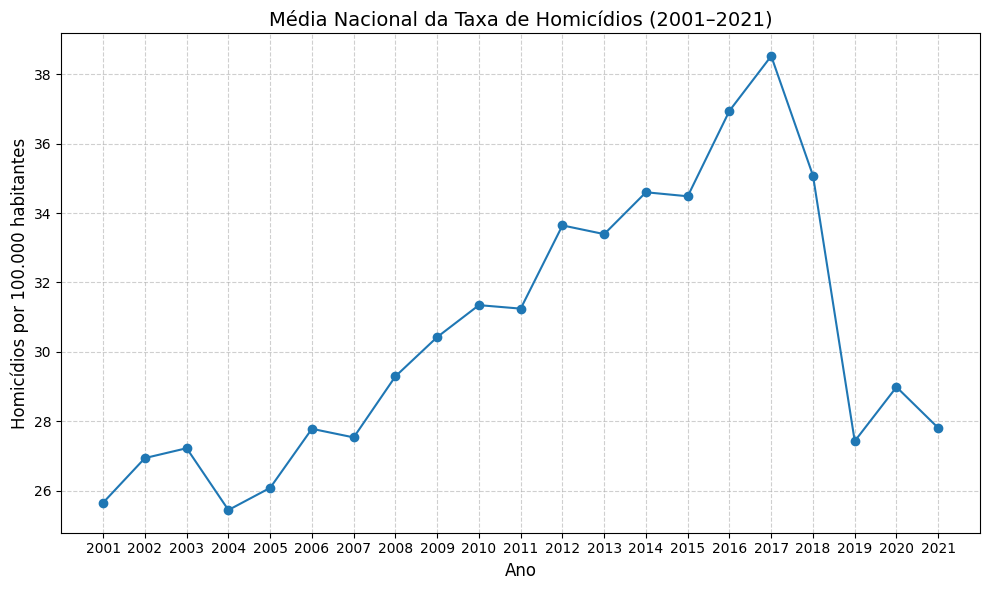

In [ ]:
import matplotlib.pyplot as plt

# 4.4.1 Evolução Média Nacional (linha)

media_ano = df.groupby('Ano')['Taxa100mil'].mean().reset_index()

# Garantir que a coluna 'Ano' seja do tipo inteiro
media_ano['Ano'] = media_ano['Ano'].astype(int)

plt.figure(figsize=(10, 6)) # Aumentar o tamanho para melhor visualização
plt.plot(media_ano['Ano'], media_ano['Taxa100mil'], marker='o', linestyle='-') # Adicionar linestyle
plt.title('Média Nacional da Taxa de Homicídios (2001–2021)', fontsize=14) # Ajustar tamanho do título
plt.xlabel('Ano', fontsize=12) # Ajustar tamanho dos labels
plt.ylabel('Homicídios por 100.000 habitantes', fontsize=12) # Ajustar tamanho dos labels
plt.xticks(media_ano['Ano']) # Definir ticks no eixo X para cada ano
plt.grid(True, linestyle='--', alpha=0.6) # Melhorar a grade
plt.tight_layout()
plt.show()

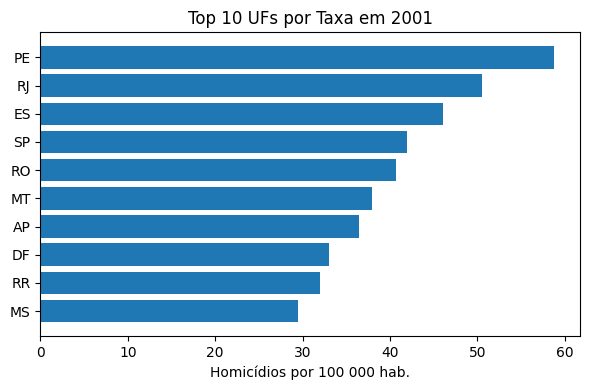

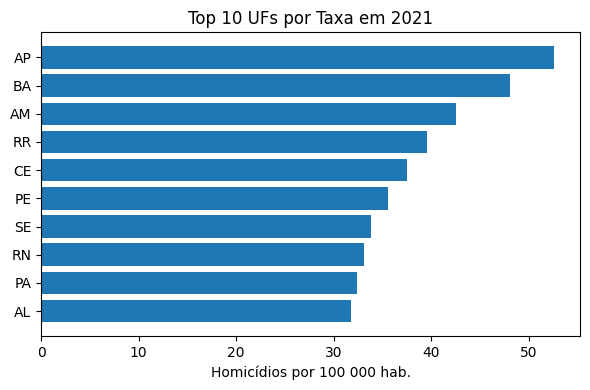

In [ ]:
# 4.4.2 Comparativo Anual

for ano in [2001, 2021]:
    top10 = df[df['Ano']==ano].nlargest(10, 'Taxa100mil')

    plt.figure(figsize=(6,4))
    plt.barh(top10['UF'], top10['Taxa100mil'])
    plt.title(f'Top 10 UFs por Taxa em {ano}')
    plt.xlabel('Homicídios por 100 000 hab.')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

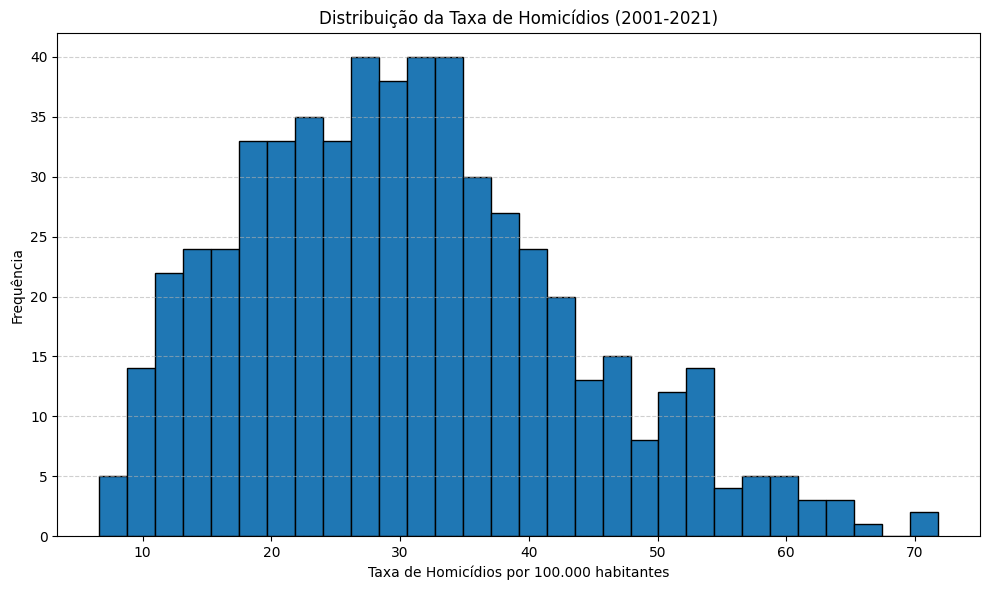

In [ ]:
# 4.4.3 Histograma da Taxa de Homicídios (geral)
plt.figure(figsize=(10, 6))
plt.hist(df['Taxa100mil'], bins=30, edgecolor='black') # Ajuste o número de bins conforme necessário
plt.title('Distribuição da Taxa de Homicídios (2001-2021)')
plt.xlabel('Taxa de Homicídios por 100.000 habitantes')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

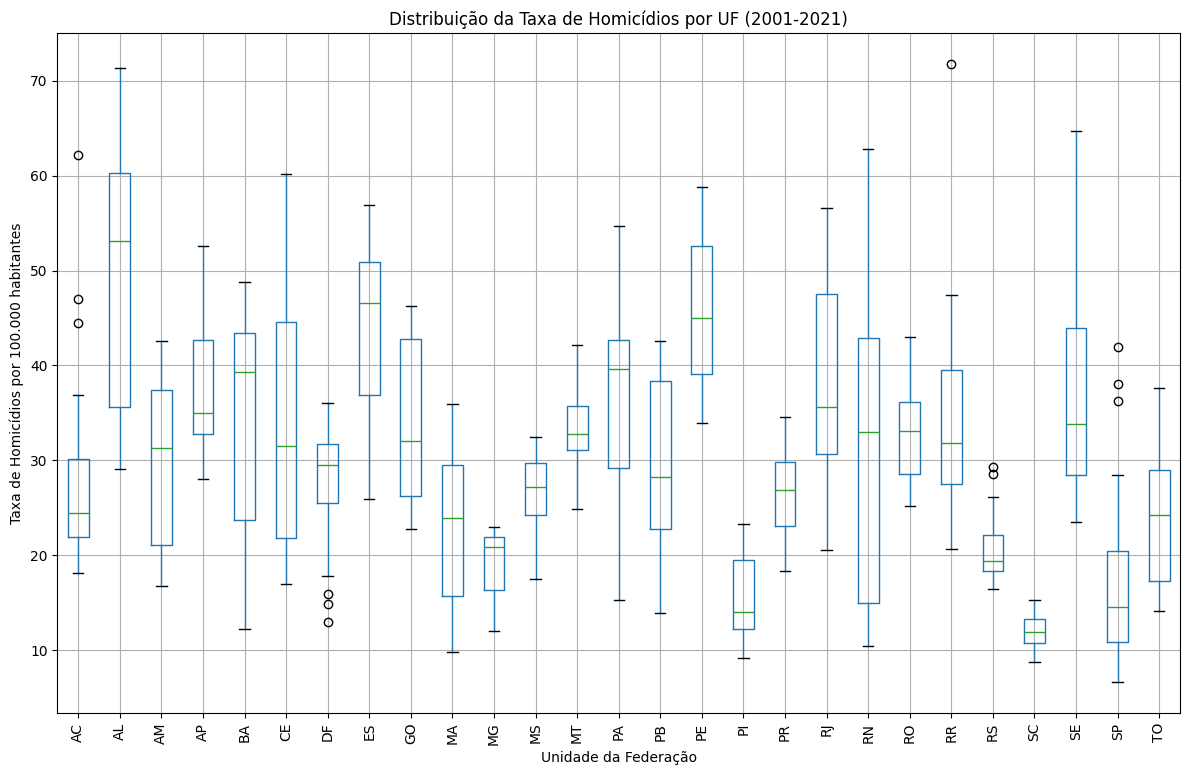

In [ ]:
# 4.4.4 Box Plot da Taxa de Homicídios por UF
plt.figure(figsize=(12, 8)) # Ajustar tamanho para acomodar todas as UFs
df[['UF', 'Taxa100mil']].boxplot(by='UF', figsize=(12, 8), rot=90)
plt.title('Distribuição da Taxa de Homicídios por UF (2001-2021)')
plt.xlabel('Unidade da Federação')
plt.ylabel('Taxa de Homicídios por 100.000 habitantes')
plt.suptitle('') # Remove o título padrão do boxplot gerado pelo pandas
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

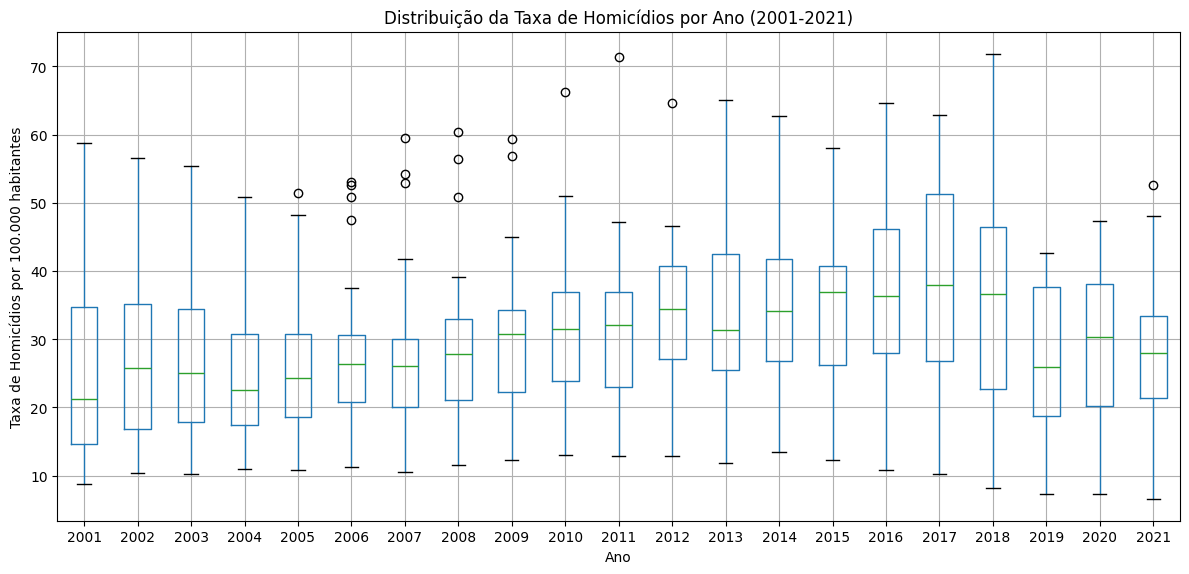

In [ ]:
# 4.4.5 Box Plot da Taxa de Homicídios por Ano
plt.figure(figsize=(12, 6)) # Ajustar tamanho
df[['Ano', 'Taxa100mil']].boxplot(by='Ano', figsize=(12, 6))
plt.title('Distribuição da Taxa de Homicídios por Ano (2001-2021)')
plt.xlabel('Ano')
plt.ylabel('Taxa de Homicídios por 100.000 habitantes')
plt.suptitle('') # Remove o título padrão do boxplot gerado pelo pandas
plt.tight_layout()
plt.show()

Top 5 UFs com maiores médias de taxa: ['AL', 'PE', 'ES', 'SE', 'RJ']


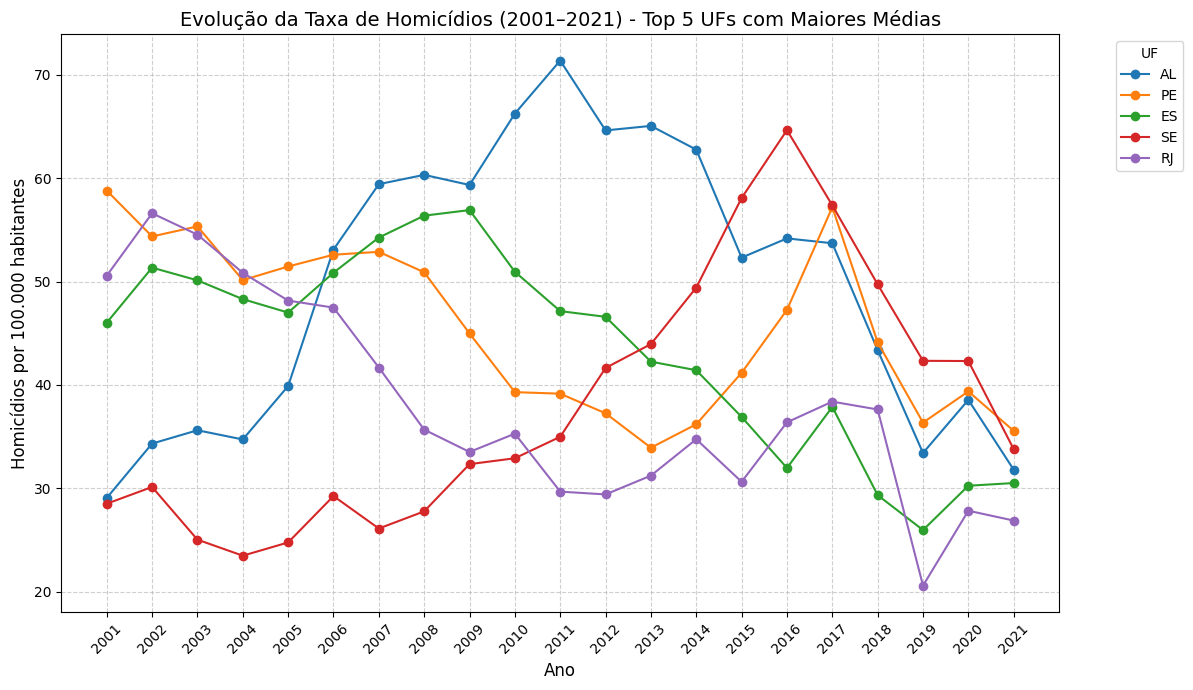

In [ ]:
# 4.4.3. Tendência das 5 UFs com maiores médias de taxa

# Identificar as 5 UFs com maiores médias de taxa (usando a estat_por_uf já calculada)
top5_ufs = estat_por_uf.head(5).index.tolist()
print("Top 5 UFs com maiores médias de taxa:", top5_ufs)

# Filtrar o DataFrame para incluir apenas essas 5 UFs
df_top5 = df[df['UF'].isin(top5_ufs)]

# Plotar as séries temporais para cada uma dessas UFs
plt.figure(figsize=(12, 7))

for uf in top5_ufs:
    serie = df_top5[df_top5['UF'] == uf].sort_values('Ano')
    plt.plot(serie['Ano'], serie['Taxa100mil'], marker='o', linestyle='-', label=uf)

plt.title('Evolução da Taxa de Homicídios (2001–2021) - Top 5 UFs com Maiores Médias', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Homicídios por 100.000 habitantes', fontsize=12)
plt.xticks(df_top5['Ano'].unique().astype(int), rotation=45) # Mostrar todos os anos no eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='UF', bbox_to_anchor=(1.05, 1), loc='upper left') # Adicionar legenda fora do plot
plt.tight_layout()
plt.show()

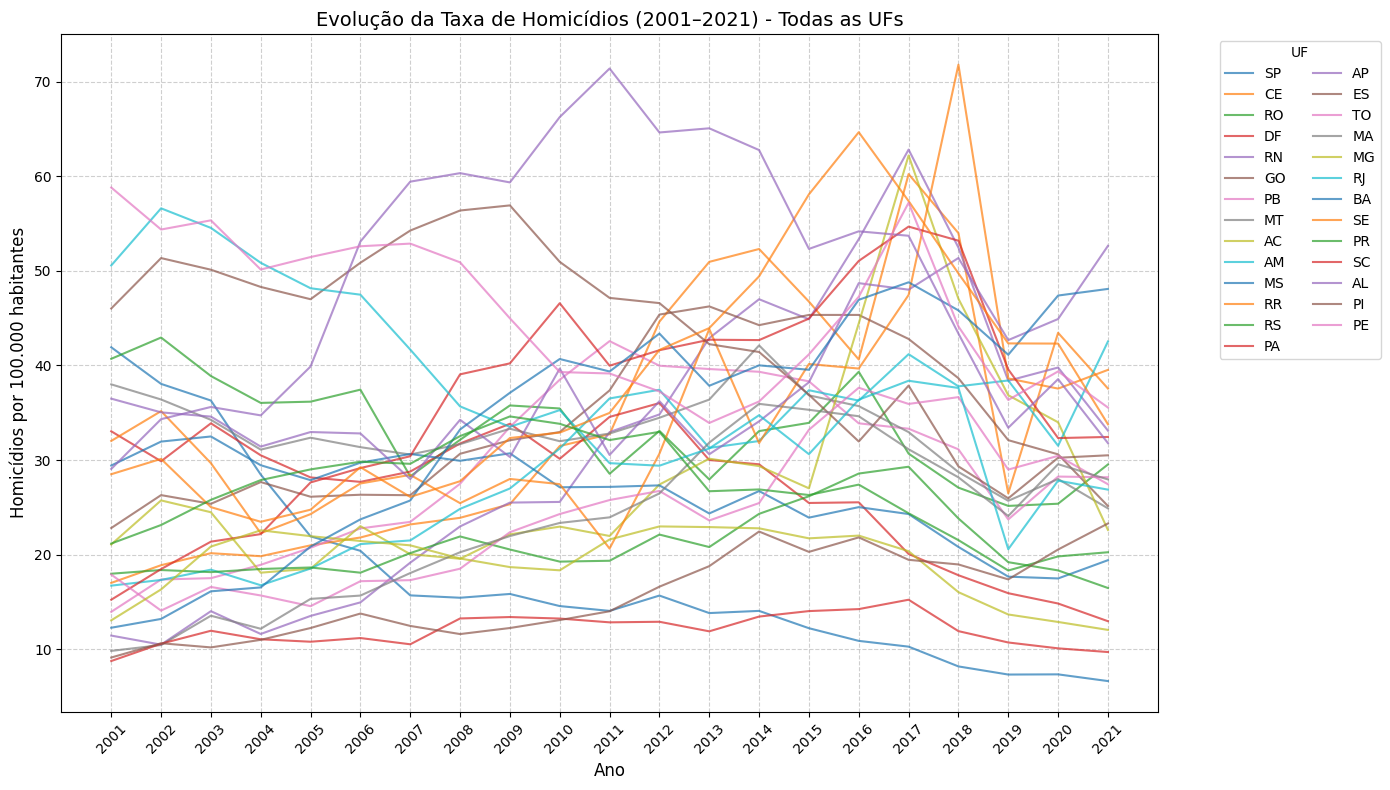

In [ ]:
# 4.4.4. Tendência de todas as UFs

plt.figure(figsize=(14, 8)) # Aumentar o tamanho para acomodar mais linhas

# Obter a lista de todas as UFs únicas no DataFrame
all_ufs = df['UF'].unique()

# Plotar as séries temporais para cada UF
for uf in all_ufs:
    serie = df[df['UF'] == uf].sort_values('Ano')
    plt.plot(serie['Ano'], serie['Taxa100mil'], marker='', linestyle='-', label=uf, alpha=0.7)

plt.title('Evolução da Taxa de Homicídios (2001–2021) - Todas as UFs', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Homicídios por 100.000 habitantes', fontsize=12)
plt.xticks(df['Ano'].unique().astype(int), rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='UF', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

# 5. Insights e Interpretações

## O que os dados mostram?

Os dados de 2001 a 2021 mostram **heterogeneidade espacial** na incidência de homicídios no Brasil. A análise descritiva geral (`df['Taxa100mil'].describe()`) e, visualmente, o **box plot por UF** demonstram a vasta diferença nas taxas entre os estados, com alguns apresentando consistentemente níveis muito mais elevados do que outros ao longo do período.

A **evolução temporal da taxa média nacional** (vista no gráfico de linha e na tabela `estat_por_ano`) indica que o Brasil passou por um período de aumento nas taxas de homicídio na primeira parte do século (atingindo um pico por volta de 2017), seguido por uma reversão de tendência e uma queda notável nos anos mais recentes (2018-2021). O **box plot por Ano** mostra como a distribuição das taxas entre os estados se comportou anualmente, revelando mudanças na dispersão e nos valores típicos ao longo do tempo.

O **histograma da taxa geral** oferece uma visão da frequência com que diferentes níveis de violência letal ocorreram nas combinações UF-Ano. Ele pode revelar, por exemplo, se há uma predominância de UFs com taxas baixas/médias ou se a distribuição é mais espalhada.

### Interpretação das Estatísticas Descritivas

As tabelas de estatísticas descritivas (geral, por ano e por UF) fornecem um resumo numérico essencial dos dados:

*   **Resumo Geral (`df['Taxa100mil'].describe()`):** Apresenta a contagem (`count`), média (`mean`), desvio padrão (`std`), mínimo (`min`), quartis (25%, 50%, 75%) e máximo (`max`) da taxa de homicídios considerando todas as observações (UF x Ano) no período. O `mean` e a mediana (`50%`) indicam a tendência central, enquanto o `std` e a amplitude (`max` - `min`) medem a dispersão.
*   **Estatísticas por Ano (`estat_por_ano`):** Exibe as mesmas métricas descritivas, mas calculadas para cada ano individualmente. Isso permite rastrear a evolução da média nacional e, crucialmente, como a **variabilidade (`std`) e a distribuição (quartis, min, max)** das taxas *entre as UFs* mudaram ano a ano. Um `std` crescente, por exemplo, indicaria que as diferenças nas taxas entre os estados se tornaram mais pronunciadas naquele ano.
*   **Estatísticas por UF (`estat_por_uf`):** Fornece as métricas descritivas para cada Unidade da Federação ao longo dos 21 anos. Analisar a média (`mean`) por UF é fundamental para identificar quais estados tiveram as taxas mais altas (ou baixas) *em média* no período. O desvio padrão (`std`) por UF mostra a **volatilidade da taxa *dentro* de cada estado** ao longo do tempo: um `std` alto para uma UF indica que sua taxa variou muito entre 2001 e 2021.

A análise conjunta destas tabelas com os gráficos é necessária para identificar padrões espaciais e temporais na violência.

Com base nas estatísticas descritivas detalhadas e nos diversos gráficos básicos gerados na Etapa 4 (evolução da média nacional, comparativos anuais dos Top 10 UFs, histograma da distribuição geral, box plots por UF e por Ano, e a tendência das Top 5 UFs com maiores médias), podemos agora extrair insights e interpretações relevantes sobre a dinâmica da taxa de homicídios por 100.000 habitantes nas Unidades da Federação entre 2001 e 2021.

## Comparações relevantes

### Variação entre UFs (Quedas/Altas Percentuais)

A comparação das taxas entre UFs em anos específicos é fundamental. Os **gráficos de barras dos Top 10 UFs em 2001 e 2021** destacam os estados que estavam no topo do ranking no início e no fim do período. A simples comparação visual entre estes dois anos já sugere movimentos diferentes: alguns estados que tinham taxas altas em 2001 podem não estar mais no Top 10 em 2021, enquanto outros podem ter entrado ou subido no ranking.

Para identificar os estados com **maiores quedas ou altas percentuais** de forma precisa, seria necessário calcular a variação percentual da taxa de 2001 para 2021 para cada UF individualmente. No entanto, a tendência das **5 UFs com maiores médias de taxa** (gráfico de série temporal) já mostra que, mesmo entre os estados mais violentos em média, as trajetórias individuais podem variar, com alguns apresentando quedas nos últimos anos (como sugerido pela média nacional) e outros talvez mantendo taxas elevadas ou com menor redução.

### Evolução regional

A análise regional é crucial para entender a dinâmica da violência no país. Embora ainda não tenhamos um gráfico de série temporal por região, a análise das **estatísticas descritivas por UF** (`estat_por_uf`) sugere que as regiões **Nordeste** e partes do **Norte** tenderam a ter as maiores taxas médias de homicídio no período. Em contrapartes, UFs do **Sul** e grande parte do **Sudeste** apresentaram taxas médias comparativamente mais baixas (com exceções notáveis como ES e RJ). A tendência nacional de queda nos últimos anos pode ter sido impulsionada por reduções significativas em UFs de regiões específicas.

## Tendências

A principal tendência observada é a do crescimento seguido por queda na taxa média nacional. No entanto, a análise dos dados também revela:

*   **Diversidade de Tendências Locais:** O gráfico de série temporal das **Top 5 UFs com maiores médias** ilustra que, embora a média nacional tenha uma tendência clara, as Unidades da Federação podem seguir padrões diferentes. Alguns estados podem ter visto aumentos contínuos, outros quedas, e alguns flutuações mais voláteis.
*   **Volatilidade:** A coluna `std` na tabela **Estatísticas por Ano** fornece um indicativo da volatilidade ou dispersão das taxas *entre os estados* a cada ano. Analisar a evolução deste `std` ao longo do tempo pode mostrar se as taxas estaduais se tornaram mais parecidas ou mais díspares com o passar dos anos. O **box plot por Ano** também ajuda a visualizar essa volatilidade (pela altura das caixas e extensão dos "bigodes").

Em resumo, os dados mostram que a violência letal é um fenômeno desigual no Brasil, com padrões espaciais persistentes e uma evolução temporal complexa que varia entre as UFs. A tendência recente de queda na média nacional é um ponto crucial a ser explorado, investigando quais estados ou regiões são os principais responsáveis por essa mudança.

# 6. Conclusão

Com base na análise da taxa de homicídios por 100.000 habitantes nas Unidades da Federação entre 2001 e 2021, utilizando dados do Atlas da Violência (IPEA) e estimativas populacionais do SIDRA/IBGE, chegamos às seguintes conclusões:

## Principais Descobertas

A análise revelou um cenário de grande disparidade na violência letal no Brasil, com taxas de homicídio variando significativamente entre os estados. Observou-se uma tendência geral de aumento na média nacional da taxa até um pico por volta de 2017, seguida por uma queda nos anos mais recentes.

Comparando a evolução em diferentes UFs, fica claro que as trajetórias de segurança pública são diversas. **Enquanto estados como São Paulo apresentaram uma redução consistente e significativa em suas taxas de homicídio ao longo do período, outras Unidades da Federação, particularmente nas regiões Nordeste e Norte, enfrentaram desafios crescentes, com algumas experimentando altas acentuadas em certos períodos.** O box plot por UF e os gráficos de série temporal para as Top 5 UFs com maiores médias de taxa ilustram vividamente essa heterogeneidade e as diferentes dinâmicas estaduais que compõem a média nacional.

## Limitações

É importante reconhecer algumas limitações nesta análise que podem afetar a precisão e a completude dos insights:

*   **Inconsistências na Notificação de Homicídios:** Os dados de homicídios dolosos são compilados de diversas fontes (Boletins de Ocorrência, laudos do IML, etc.), e pode haver variações metodológicas ou inconsistências na notificação e registro desses eventos entre os diferentes estados e ao longo do tempo.
*   **Estimativas Populacionais:** O Censo Demográfico oficial é realizado apenas a cada 10 anos. As populações para os anos intermediários são estimativas do IBGE, que, embora robustas, podem ter margens de erro que impactam o cálculo preciso da taxa por 100.000 habitantes. A ausência de dados para 2007 e 2010 na fonte primária do IBGE (que exigiu interpolação) é um exemplo direto dessa limitação.

## Sugestões para Estudos Futuros

Para aprofundar a compreensão da dinâmica da violência letal no Brasil e complementar esta análise, sugerem-se as seguintes direções para estudos futuros:

*   **Incluir Variáveis Socioeconômicas:** Analisar a correlação entre a taxa de homicídios e variáveis socioeconômicas como renda per capita, nível de escolaridade, desigualdade social e acesso a serviços públicos. Isso pode ajudar a identificar fatores subjacentes associados aos diferentes níveis de violência.
*   **Análise de Outros Tipos de Violência:** Expandir a análise para incluir outros indicadores de violência e criminalidade (por exemplo, roubos, furtos, lesões corporais) para obter um panorama mais completo da segurança pública.
*   **Análise de Políticas Públicas:** Investigar o impacto de políticas de segurança pública e intervenções sociais implementadas em diferentes UFs para tentar correlacionar as mudanças nas taxas de homicídio com ações específicas.
*   **Análise Espacial Detalhada:** Se dados disponíveis permitirem, realizar análises em níveis geográficos mais desagregados (municípios, bairros) para identificar "hotspots" de violência e padrões espaciais mais finos.

# 7. Referências

*   **Atlas da Violência – IPEA:** <https://www.ipea.gov.br/atlasviolencia/>
*   **SIDRA/IBGE, Tabela 6579:** <https://sidra.ibge.gov.br/tabela/6579>